# Neural Style Transfer type Synthesis but with a VAE and two triplet encoders

In [1]:
import scripts.init_gpu as init_gpu
import scripts.init_dataset as init_dataset
from scripts.triplet_functions import n_neurons
import pandas as pd


init_gpu.initialize_gpus()

locations = ['LOC1', 'LOC2']

print("Loading Dataset...")
# load the dataset
df = pd.read_csv(
    f"../dataset/processed/{locations[0]}-{locations[1]}-scaled-balanced.csv")

length = len(df.columns) - 2  # subtract the two label columns

# get train-test set
train_df, test_df, train_web_samples, test_web_samples = init_dataset.get_sample(
    df, locations, range(1500), 1200)

train_df.head()

2024-11-25 14:26:44.648396: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-25 14:26:44.655703: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732505204.664026  109330 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732505204.666488  109330 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-25 14:26:44.675187: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Num GPUs Available:  2
Loading Dataset...
Training Websites: [1309, 228, 51, 563, 501, 457, 285, 209, 1385, 1116, 178, 1209, 864, 65, 61, 191, 447, 476, 1034, 1232, 54, 1149, 407, 1466, 1330, 1436, 1490, 859, 451, 919, 1206, 569, 13, 326, 1429, 865, 696, 1468, 318, 440, 689, 1492, 189, 778, 198, 735, 704, 1236, 541, 88, 940, 1098, 255, 775, 161, 1130, 600, 1287, 1266, 740, 1182, 393, 142, 93, 1354, 466, 592, 163, 1482, 206, 1456, 1462, 928, 1301, 747, 333, 758, 727, 429, 1372, 546, 1399, 1327, 146, 1247, 1300, 350, 1093, 1495, 334, 946, 777, 552, 1310, 1140, 449, 1402, 664, 114, 469, 1486, 646, 821, 548, 135, 432, 1161, 644, 435, 1342, 1022, 810, 1316, 939, 292, 542, 1493, 505, 1478, 1103, 538, 1197, 877, 1195, 817, 741, 1404, 283, 1043, 1010, 186, 96, 224, 313, 1285, 327, 1487, 1221, 130, 788, 781, 1220, 958, 1083, 514, 1133, 23, 234, 1099, 1419, 1312, 1463, 1498, 601, 890, 323, 929, 6, 539, 1025, 365, 1039, 217, 1280, 611, 1308, 1338, 1415, 1477, 1366, 765, 330, 1104, 1086, 1, 1226, 

/home/asil0892/doh_traffic_analysis/code/scripts/init_dataset.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.sort_values(by=["Location"], inplace=True)


,Location,Website,0,1,2,3,4,5,6,7,...,116,117,118,119,120,121,122,123,124,125
0,LOC1,0,-1.086861,0.690199,0.647933,0.201517,0.207139,-0.031855,-0.316768,0.824649,...,0.055571,0.160203,0.121677,0.093533,0.09274,0.057062,0.155991,0.109839,0.086282,0.08604
1,LOC1,1005,1.095547,-1.585943,0.647933,0.343653,0.207139,-0.031855,-0.316768,0.824649,...,0.055571,0.160203,0.121677,0.093533,0.09274,0.057062,0.155991,0.109839,0.086282,0.08604
2,LOC1,1005,1.095547,0.780047,-1.972790,0.343653,0.207139,-0.031855,-0.316768,0.824649,...,0.055571,0.160203,0.121677,0.093533,0.09274,0.057062,0.155991,0.109839,0.086282,0.08604
3,LOC1,1005,-1.086861,0.690199,0.647933,0.343653,0.207139,-0.031855,-0.316768,0.824649,...,0.055571,0.160203,0.121677,0.093533,0.09274,0.057062,0.155991,0.109839,0.086282,0.08604
4,LOC1,1005,1.095547,0.780047,0.183501,-0.828965,-2.083179,-0.031855,-0.316768,0.824649,...,0.055571,0.160203,0.121677,0.093533,0.09274,0.057062,0.155991,0.109839,0.086282,0.08604


In [2]:
import tensorflow as tf
from scripts.train_vae import VAE, Sampling, ConvVAE, ConvVAE_BatchNorm

# load models

latent_dim = 96
vae_model = tf.keras.models.load_model("../models/vae/ci_vae/ConvBased/domain_and_class/checkpoints/LOC1-LOC2-e880-mse1-kl0.01-cl1.0-ConvBatchNorm-ldim96-hdim128.keras", custom_objects={'ConvVAE_BatchNorm': ConvVAE_BatchNorm, 'Sampling': Sampling})
web_model = tf.keras.models.load_model(f"../models/website/{locations[0]}-{locations[1]}-baseGRU-epochs100-train_samples1200-triplet_samples5-domain_invariant-l1.keras")
location_classifier = tf.keras.models.load_model(f"../models/classification/location/dense.keras")
latent_location_classifier = tf.keras.models.load_model(f"../models/classification/location/latent_ci_vae-e880_both_classifier.keras")
triplet_location_classifier = tf.keras.models.load_model(f"../models/classification/location/triplet_classifier.keras")

/home/asil0892/doh_traffic_analysis/.venv/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
I0000 00:00:1732505229.791067  109330 gpu_process_state.cc:201] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1732505229.791164  109330 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3840 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9
I0000 00:00:1732505229.791362  109330 gpu_process_state.cc:201] Using CUDA malloc Async allocator for GPU: 1
I0000 00:00:1732505229.791432  109330 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 19505 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:71:00.0, compute capability: 8.9


In [9]:
# web content classifier model for debugging and analysing only: DO NOT USE FOR A LOSS FUNCTION
# load classifier corresponding to the triplet model
import joblib
from sklearn.preprocessing import LabelEncoder
from scripts.classification import preprocess_data_for_web_classification

knn_web_classifier = joblib.load("../models/classification/website/KNN-TripletEpochs200-Samples5-DomainInvariant.pkl")


# Get location hyperplane

In [4]:
from scripts.classification import evaluate_classification_model, preprocess_data_for_platform_classification
from sklearn import svm
import numpy as np


def get_z_embeddings(data, vae_model=vae_model):
    embeddings = []
    chunk_size = 200
    for i in range(0, len(data), chunk_size):
        chunk = data[i:i+chunk_size]
        _, _, transformed_chunk = vae_model.encode(chunk)
        embeddings.append(transformed_chunk)

    return np.vstack(embeddings)

X_train, X_test, y_train, y_test, le = preprocess_data_for_platform_classification(train_df, test_df)
X_train_latent = get_z_embeddings(X_train)
X_test_latent = get_z_embeddings(X_test)



svm_loc_clf = svm.LinearSVC()
evaluate_classification_model(X_train_latent, y_train, X_test_latent, y_test, svm_loc_clf)


weights = svm_loc_clf.coef_.flatten()
bias = svm_loc_clf.intercept_.flatten()

# Normalize the weight vector
w_norm = weights / np.linalg.norm(weights)

I0000 00:00:1732505608.504506  128013 cuda_dnn.cc:529] Loaded cuDNN version 90300


Accuracy: 82.54, F1 Score:  82.43, Precision:  83.40, Recall:  82.54


In [5]:
def jump_to_other_side(z, w, b, alpha=0.1, mirrored=True):
    """
    Jump directly to the other side of the hyperplane.
    
    Parameters:
    - z: The current latent vector (numpy array).
    - w: The normal vector of the hyperplane.
    - b: The bias term of the hyperplane.
    - alpha: Additional step size to cross to the other side.
    
    Returns:
    - z_new: The updated latent vector on the other side.
    """
    # Compute the current value of the decision function
    decision_value = np.dot(w, z) + b
    
    # Compute the displacement to the hyperplane
    delta_z = -decision_value / np.dot(w, w) * w
    
    if mirrored:
        # mirror image of the point
        z_new = z + 2 * delta_z
    else: 
        # Add an additional step to cross the hyperplane
        z_new = z + delta_z + alpha * w

    return z_new

# synthesize data

In [18]:
import numpy as np
import tensorflow as tf

class TrafficSynthesisModel(tf.keras.Model):
    def __init__(self, vae_model, website_model, location_classifier, latent_location_classifier, triplet_location_classifier, v_source, z_mirrored, target_location):
        super(TrafficSynthesisModel, self).__init__()
        
        # Models
        self.vae_model = vae_model
        self.website_model = website_model
        self.location_classifier = location_classifier
        self.latent_location_classifier = latent_location_classifier
        self.triplet_location_classifier = triplet_location_classifier

        # Fix the weights of the other models
        self._freeze_models()

        # Data and embeddings
        self.v_synth = v_source
        self.website_embedding = website_model(v_source)

        # 
        self.latent_embedding = tf.Variable(z_mirrored)
        # self.latent_embedding = tf.Variable(tf.random.normal(shape=(1, vae_model.latent_dim), mean=0, stddev=1))
        
        # Location target
        self.target_location = self._set_target_location(target_location)

        # Hyperparameters
        self.epsilon = 1e-6 # To avoid division by zero in log calculations
        self.max_annealing_epoch = 500
        self.max_reg_weight = 0.01
        self.max_website_weight = 1

        # Loss storage
        self.website_losses = []
        self.location_losses = []
        self.original_losses = []

    def _freeze_models(self):
        self.website_model.trainable = False
        self.location_classifier.trainable = False
        self.vae_model.trainable = False
        self.triplet_location_classifier.trainable = False

    def _set_target_location(self, target_location):
        if target_location == 'LOC1':
            return tf.constant(0.0, dtype=tf.float32)
        elif target_location == 'LOC2':
            return tf.constant(1.0, dtype=tf.float32)
        else:
            raise Exception('Invalid Location')

    def compute_latent_prior_loss(self, z):
        mean_loss = tf.reduce_mean(tf.square(z))
        magnitude_loss = tf.abs(tf.reduce_sum(tf.square(z)) - tf.cast(tf.shape(z)[1], tf.float32))
        return mean_loss, magnitude_loss
    
    def get_location_classifier_weight(self, loss):
        if loss < 0.5:
            return 0
        return 1
        
    def get_regularization_weight(self, epoch):
        return self.max_reg_weight * min(epoch / self.max_annealing_epoch, 1.0)
    
    def get_website_weight(self, epoch):
        return self.max_website_weight * min(epoch / self.max_annealing_epoch, 1.0)

    def get_euclidean_distance(self, vector_a, vector_b):
        return tf.reduce_mean(tf.square(vector_a - vector_b))

    def compute_losses(self, epoch):
        """Calculate and return individual loss components as a dictionary."""
        
        losses = {}
        
        self.v_synth = self.vae_model.decode(self.latent_embedding)
        synth_triplet_embedding = self.website_model(self.v_synth)
        
        # Website reconstruction loss
        losses["website_loss"] = self.get_euclidean_distance(self.website_embedding, synth_triplet_embedding)

        # Synthesized trace location classification loss
        predicted_location = tf.clip_by_value(self.location_classifier(self.v_synth)[0][0], self.epsilon, 1 - self.epsilon)
        losses["classification_loss"] = - (self.target_location * tf.math.log(predicted_location) + (1 - self.target_location) * tf.math.log(1 - predicted_location))

        # Latent location classification loss
        predicted_location = tf.clip_by_value(self.latent_location_classifier(self.latent_embedding)[0][0], self.epsilon, 1 - self.epsilon)
        losses["latent_classification_loss"] = - (self.target_location * tf.math.log(predicted_location) + (1 - self.target_location) * tf.math.log(1 - predicted_location))
        # losses["latent_classification_loss"] = 1 - predicted_location

        # Triplet location classification loss
        # predicted_location = tf.clip_by_value(self.triplet_location_classifier(synth_triplet_embedding)[0][0], self.epsilon, 1 - self.epsilon)
        # losses["triplet_classification_loss"] = - (self.target_location * tf.math.log(predicted_location) + (1 - self.target_location) * tf.math.log(1 - predicted_location))

        # Prior losses
        prior_mean_loss, prior_magnitude_loss = self.compute_latent_prior_loss(self.latent_embedding)
        losses["prior_mean_loss"] = prior_mean_loss
        losses["prior_magnitude_loss"] = prior_magnitude_loss

        # Store losses for logging or analysis
        self.website_losses.append(losses["website_loss"])
        self.location_losses.append(losses["classification_loss"])

        # Compute total loss by summing all loss components
        total_loss = (
            # self.get_location_classifier_weight(losses['classification_loss']) * losses['classification_loss'] +
            losses['latent_classification_loss'] +
            losses['website_loss'] 
            # 0.01 * losses['prior_mean_loss'] +
            # 0.001 * losses['prior_magnitude_loss']
        )
        return total_loss, losses

    def train_step(self, epoch):
        with tf.GradientTape() as tape:
            total_loss, losses = self.compute_losses(epoch)
        
        gradients = tape.gradient(total_loss, [self.latent_embedding])

        # gradient clipping
        gradients, global_norm = tf.clip_by_global_norm(gradients, clip_norm=1.0)

        
        self.optimizer.apply_gradients(zip(gradients, [self.latent_embedding]))
        
        return total_loss, losses

    def fit(self, epochs=1000, lr=0.01):
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        
        for epoch in range(epochs):
            total_loss, losses = self.train_step(epoch)

            # TODO: Implement early stop based on some critieria
            # if (losses["latent_classification_loss"] <= 0.2) or (losses["website_loss"] <= 0.02):
            #     print(f"Early stopping triggered at epoch {epoch}. Loss: {total_loss.numpy()}")
            #     print(f"\tLosses: {losses}")
            #     break

            if epoch % 100 == 0:
                float_losses = {k: v.numpy() for k, v in losses.items()}
                print(f"Epoch {epoch}, Total Loss: {total_loss.numpy()}")
                print(f"\tLosses: {float_losses}")
        
        return self.v_synth.numpy(), self.latent_embedding.numpy(), losses["classification_loss"].numpy()


In [ ]:
# import numpy as np
# import tensorflow as tf

# class TrafficSynthesisModelAdjusted(TrafficSynthesisModel):
#     def __init__(self, vae_model, website_model, location_classifier, latent_location_classifier, v_source, target_location):
#         super().__init__(vae_model, website_model, location_classifier, latent_location_classifier, v_source, target_location)
        
#         # Initialize additional statistics and parameters
#         # self.initial_stats = self._compute_initial_statistics()
        
#         # Dynamic loss weights (as float32)
#         self.website_scale = 1.0
#         self.location_scale = 1.0
#         self.kl_weight = 1.0
#         # self.distribution_weight = tf.cast(0.1, dtype=tf.float32)
        
#         # Moving averages for loss balancing
#         self.loss_ema = {
#             'website': None,
#             'location': None
#         }
#         self.ema_decay = tf.cast(0.99, dtype=tf.float32)

#     # def _compute_initial_statistics(self):
#     #     """Compute initial statistics of the source data for distribution matching"""
#     #     return {
#     #         'mean': tf.cast(tf.reduce_mean(self.v_synth), dtype=tf.float32),
#     #         'std': tf.cast(tf.math.reduce_std(self.v_synth), dtype=tf.float32),
#     #         'max': tf.cast(tf.reduce_max(self.v_synth), dtype=tf.float32),
#     #         'min': tf.cast(tf.reduce_min(self.v_synth), dtype=tf.float32)
#     #     }

#     def _update_loss_scales(self, website_loss, location_loss):
#         """Dynamically update loss scaling factors based on exponential moving averages"""
#         # Ensure losses are float32
#         website_loss = tf.cast(website_loss, dtype=tf.float32)
#         location_loss = tf.cast(location_loss, dtype=tf.float32)
        
#         # Update EMAs
#         for loss_type, current_loss in [('website', website_loss), ('location', location_loss)]:
#             if self.loss_ema[loss_type] is None:
#                 self.loss_ema[loss_type] = current_loss
#             else:
#                 self.loss_ema[loss_type] = (
#                     self.ema_decay * self.loss_ema[loss_type] + 
#                     (1 - self.ema_decay) * current_loss
#                 )

#         # Compute relative scales to balance losses
#         if all(v is not None for v in self.loss_ema.values()):
#             max_ema = tf.cast(tf.maximum(self.loss_ema['website'], self.loss_ema['location']), dtype=tf.float32)
#             self.website_scale = max_ema / (tf.cast(self.loss_ema['website'], dtype=tf.float32) + self.epsilon)
#             self.location_scale = max_ema / (tf.cast(self.loss_ema['location'], dtype=tf.float32) + self.epsilon)

#     # def compute_distribution_matching_loss(self, synthetic_trace):
#     #     """Compute loss terms for matching the statistical properties of the original trace"""
#     #     # Ensure all computations are in float32
#     #     synth_mean = tf.cast(tf.reduce_mean(synthetic_trace), dtype=tf.float32)
#     #     synth_std = tf.cast(tf.math.reduce_std(synthetic_trace), dtype=tf.float32)
#     #     synth_max = tf.cast(tf.reduce_max(synthetic_trace), dtype=tf.float32)
#     #     synth_min = tf.cast(tf.reduce_min(synthetic_trace), dtype=tf.float32)
        
#     #     mean_loss = tf.square(synth_mean - self.initial_stats['mean'])
#     #     std_loss = tf.square(synth_std - self.initial_stats['std'])
#     #     range_loss = (
#     #         tf.square(synth_max - self.initial_stats['max']) + 
#     #         tf.square(synth_min - self.initial_stats['min'])
#     #     )
        
#     #     return mean_loss + std_loss + tf.cast(0.1, dtype=tf.float32) * range_loss

#     def compute_kl_regularization(self, z):
#         """Compute KL divergence loss to ensure latent space follows Gaussian distribution"""
#         # Ensure z is float32
#         z = tf.cast(z, dtype=tf.float32)
        
#         mean_sq = tf.reduce_mean(tf.square(z))
#         log_var = tf.math.log(tf.math.reduce_variance(z) + self.epsilon)
        
#         kl_loss = tf.cast(0.5, dtype=tf.float32) * tf.reduce_mean(
#             mean_sq + tf.exp(log_var) - tf.cast(1.0, dtype=tf.float32) - log_var
#         )
#         return kl_loss

#     def compute_losses(self, epoch):
#         """Calculate and return individual loss components as a dictionary."""
#         self.v_synth = self.vae_model.decode(self.latent_embedding)
        
#         losses = {}

#         # Basic losses (ensure float32)
#         website_loss = tf.cast(
#             self.get_euclidean_distance(
#                 self.website_embedding, 
#                 self.website_model(self.v_synth)
#             ),
#             dtype=tf.float32
#         )
        
#         predicted_location = tf.clip_by_value(
#             self.latent_location_classifier(self.latent_embedding)[0][0], 
#             self.epsilon, 
#             1 - self.epsilon
#         )
#         location_loss = tf.cast(-(
#             self.target_location * tf.math.log(predicted_location) + 
#             (1 - self.target_location) * tf.math.log(1 - predicted_location)
#         ), dtype=tf.float32)
    

#         # Update scaling factors
#         self._update_loss_scales(website_loss, location_loss)

#         # Store scaled losses
#         losses["website_loss"] = self.website_scale * website_loss
#         losses["classification_loss"] = self.location_scale * location_loss

#         # Distribution constraints
#         losses["kl_loss"] = self.kl_weight * self.compute_kl_regularization(self.latent_embedding)
#         # losses["distribution_loss"] = self.distribution_weight * self.compute_distribution_matching_loss(self.v_synth)

#         # Store unscaled losses for logging
#         self.website_losses.append(website_loss)
#         self.location_losses.append(location_loss)

#         # Compute total loss
#         total_loss = (
#             losses['classification_loss'] +
#             losses['website_loss'] + 
#             losses['kl_loss'] 
#         )

        
#         return total_loss, losses

#     def fit(self, epochs=1000, lr=0.01):
#         """Override fit method to use Adam optimizer and provide more detailed logging"""
#         self.optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        
#         history = {
#             'total_loss': [],
#             'website_loss': [],
#             'classification_loss': [],
#             'kl_loss': [],
#             # 'distribution_loss': [],
#             'website_scale': [],
#             'location_scale': []
#         }
        
#         for epoch in range(epochs):
#             total_loss, losses = self.train_step(epoch)
            
#             # Store history
#             history['total_loss'].append(float(total_loss.numpy()))
#             for k, v in losses.items():
#                 history[k].append(float(v.numpy()))
#             history['website_scale'].append(float(self.website_scale))
#             history['location_scale'].append(float(self.location_scale))

#             if epoch % 100 == 0:
#                 float_losses = {k: v.numpy() for k, v in losses.items()}
#                 print(f"Epoch {epoch}, Total Loss: {float(total_loss.numpy()):.4f}")
#                 print(f"\tLosses: {float_losses}")
#                 print(f"\tScales - Website: {float(self.website_scale):.4f}, Location: {float(self.location_scale):.4f}")
        
#         return (
#             self.v_synth.numpy(), 
#             self.latent_embedding.numpy(), 
#             losses["classification_loss"].numpy(),
#             losses["kl_loss"].numpy()
#         )

In [19]:
import random
random_seed = 42
target_location = 'LOC2'
source_location = 'LOC1'
synthesized_vectors = []
mirrored_latent_embeddings = []
synth_latent_embeddings = []

target_website = 8
target_data = test_df[(test_df['Website'] == target_website) & (test_df['Location'] == target_location)].iloc[:, 2:].to_numpy()

_, _, _, _, le = preprocess_data_for_web_classification(test_df, source_location, target_location) 

i = 0
num_samples = 4
while i != num_samples:
    print(f"{i+1} of {num_samples}...")


    source_trace = test_df[(test_df['Location'] == source_location) & (
        test_df['Website'] == target_website)].iloc[:, 2:].sample()

    source_trace = source_trace.to_numpy().reshape(1, length, 1)

    _, _, source_latent = vae_model.encode(source_trace)
    
    # TODO: Add some loop to make the latent embedding go further away from the hyperplane boundary
    mirrored_latent = jump_to_other_side(source_latent[0], w_norm, bias, mirrored=True)

    # initialize model
    print("Initializing TSM Model...")
    tsm_model = TrafficSynthesisModel(vae_model, web_model, location_classifier, latent_location_classifier, triplet_location_classifier, source_trace, mirrored_latent.numpy().reshape(1, -1), target_location)
    # synthesize
    epochs = 1000
    lr = 0.0001
    
    
    print("Synthesizing Trace...")
    synthesized_vector, synth_z, location_trace_classification_loss = tsm_model.fit(epochs=epochs, lr=lr)

    # if not a good synthesis: Based on location classification
    # if (latent_classification_loss > 0.2) or (location_trace_classification_loss > 0.4):
    #     print("Neglecting this one, not a good synthesis...")
    #     continue
    
    synthesized_vectors.append(synthesized_vector)
    synth_latent_embeddings.append(synth_z)
    mirrored_latent_embeddings.append(mirrored_latent)
    i += 1

synth_latent_embeddings = np.array(synth_latent_embeddings).reshape(num_samples, vae_model.latent_dim)
synthesized_vectors = np.array(synthesized_vectors).reshape(num_samples, length)

1 of 4...
Initializing TSM Model...
Synthesizing Trace...
Epoch 0, Total Loss: 5.440330982208252
	Losses: {'website_loss': 0.013875318, 'classification_loss': 13.815511, 'latent_classification_loss': 5.4264555, 'prior_mean_loss': 4.6195292, 'prior_magnitude_loss': 347.47482}
Epoch 100, Total Loss: 4.895877361297607
	Losses: {'website_loss': 0.0139239095, 'classification_loss': 13.815511, 'latent_classification_loss': 4.8819532, 'prior_mean_loss': 4.6188884, 'prior_magnitude_loss': 347.41327}
Epoch 200, Total Loss: 4.3950700759887695
	Losses: {'website_loss': 0.013977576, 'classification_loss': 13.815511, 'latent_classification_loss': 4.3810925, 'prior_mean_loss': 4.620278, 'prior_magnitude_loss': 347.5467}
Epoch 300, Total Loss: 3.9514782428741455
	Losses: {'website_loss': 0.013848598, 'classification_loss': 13.815511, 'latent_classification_loss': 3.9376297, 'prior_mean_loss': 4.6209373, 'prior_magnitude_loss': 347.61}
Epoch 400, Total Loss: 3.546182632446289
	Losses: {'website_loss':

# Analyzing the synthesized data

### Finding the actual nearest neighbour to the synthesized latent embedding

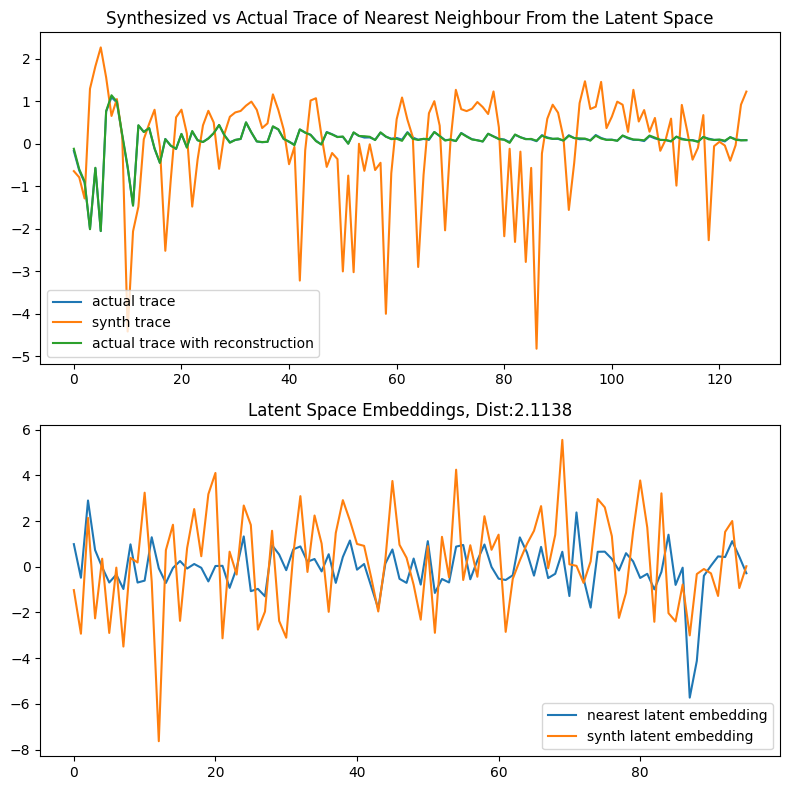

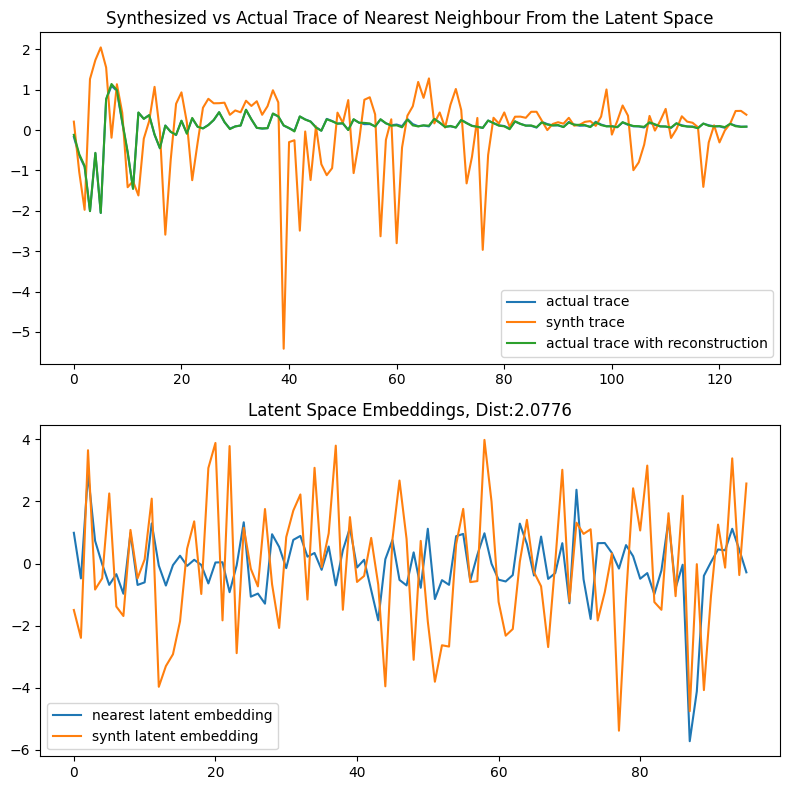

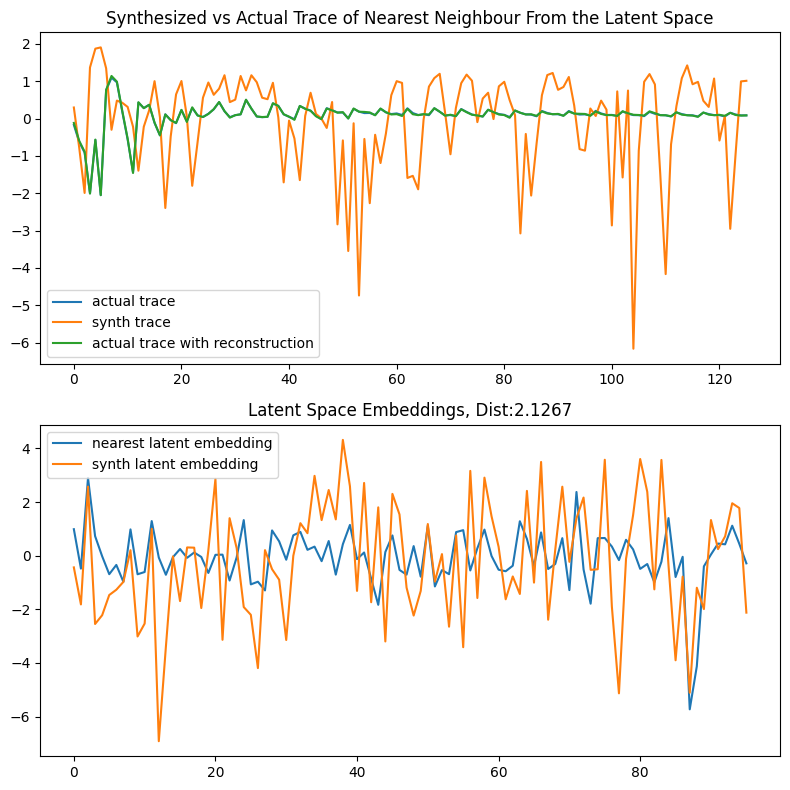

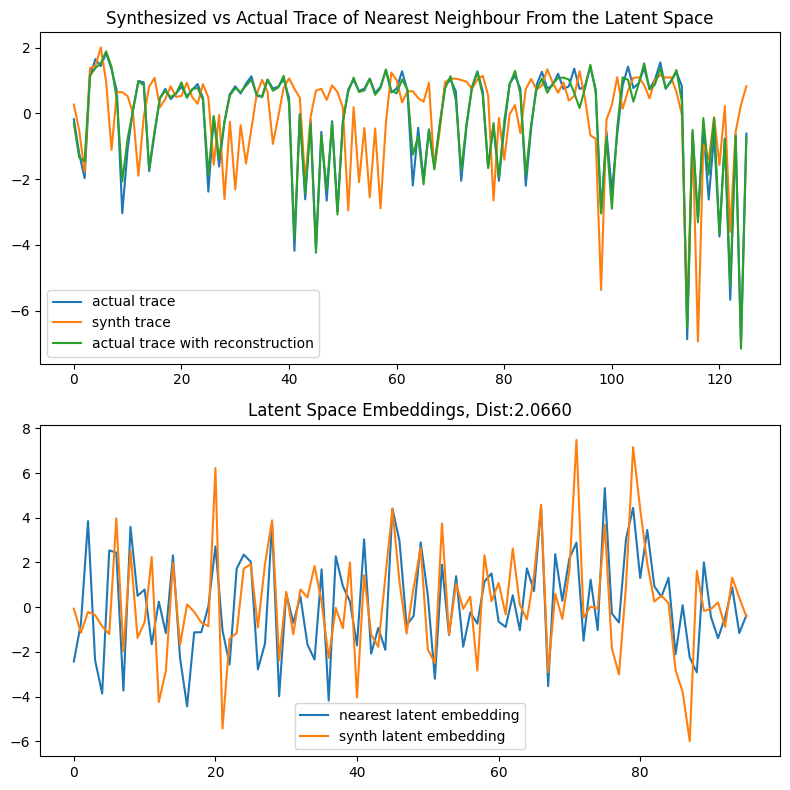

In [20]:
# Finding nearest neighbour to the traversed latent vector and comparing the reconstructions
import matplotlib.pyplot as plt
_, _, target_latent_embeddings = vae_model.encode(target_data)

for i in range(num_samples):
    z = synth_latent_embeddings[i]
    synth_trace = synthesized_vectors[i]
    # Compute Euclidean distances from `z` to each embedding in `embeddings_set`
    distances = tf.sqrt(tf.reduce_mean(tf.square(target_latent_embeddings - z), axis=1))

    # Find the index of the closest embedding
    nearest_neighbor_index = tf.argmin(distances)

    # Get the nearest neighbor embedding and its distance
    nearest_neighbor = target_latent_embeddings[nearest_neighbor_index]
    nearest_distance = distances[nearest_neighbor_index]

    actual_trace = target_data[nearest_neighbor_index]
    actual_trace_reconstructed_by_vae = vae_model.decode(nearest_neighbor.numpy().reshape(1, vae_model.latent_dim))[0]
    
    plt.figure(figsize=(8,8))
    plt.subplot(2, 1, 1)
    plt.plot(actual_trace, label='actual trace')
    plt.plot(synth_trace, label='synth trace')
    plt.plot(actual_trace_reconstructed_by_vae, label='actual trace with reconstruction')
    plt.title("Synthesized vs Actual Trace of Nearest Neighbour From the Latent Space")
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(nearest_neighbor, label='nearest latent embedding')
    plt.plot(z, label='synth latent embedding')
    plt.legend()
    plt.title(f"Latent Space Embeddings, Dist:{nearest_distance:.4f}")
    plt.tight_layout()
    plt.show()
    plt.close()
    

# Website Classification: Does the synthesized triplet embedding belong to the correct class?

In [21]:
reconstructed_target_data, _, _ = vae_model(target_data)
y_pred_actual_target = knn_web_classifier.predict(web_model(reconstructed_target_data))
for i in range(len(target_data)):
    predicted_website = le.classes_[y_pred_actual_target[i]]
    print(f"Actual Website: {target_website}, Predicted Website for Real Traffic: {predicted_website}")


y_pred_synth_arr = knn_web_classifier.predict(web_model(synthesized_vectors))
for i in range(num_samples):
    predicted_website = le.classes_[y_pred_synth_arr[i]]
    print(f"\n\nActual Website: {target_website}, Predicted Website for synthesized traffic: {predicted_website}")

Actual Website: 8, Predicted Website for Real Traffic: 1164
Actual Website: 8, Predicted Website for Real Traffic: 1297
Actual Website: 8, Predicted Website for Real Traffic: 49
Actual Website: 8, Predicted Website for Real Traffic: 917
Actual Website: 8, Predicted Website for Real Traffic: 520
Actual Website: 8, Predicted Website for Real Traffic: 342
Actual Website: 8, Predicted Website for Real Traffic: 213
Actual Website: 8, Predicted Website for Real Traffic: 547
Actual Website: 8, Predicted Website for Real Traffic: 8
Actual Website: 8, Predicted Website for Real Traffic: 49
Actual Website: 8, Predicted Website for Real Traffic: 368
Actual Website: 8, Predicted Website for Real Traffic: 9
Actual Website: 8, Predicted Website for Real Traffic: 368
Actual Website: 8, Predicted Website for Real Traffic: 474
Actual Website: 8, Predicted Website for Real Traffic: 1181
Actual Website: 8, Predicted Website for Real Traffic: 342
Actual Website: 8, Predicted Website for Real Traffic: 126


# Plotting the target distribution of traces and synthesized traces

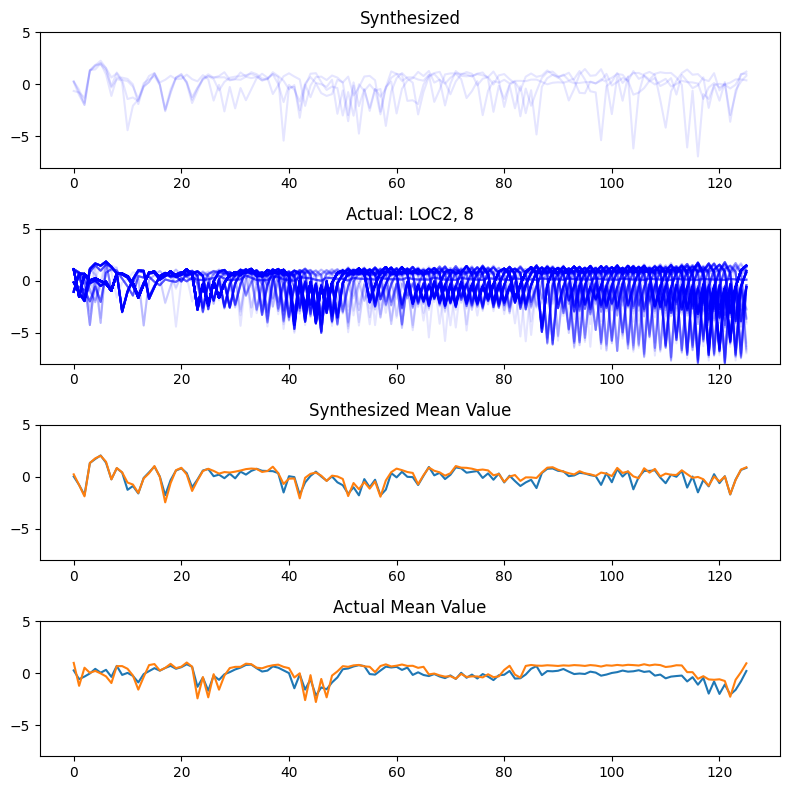

In [22]:
import matplotlib.pyplot as plt


plt.figure(figsize=(8, 8))
plt.subplot(4,1,1)
for i in range(num_samples):
    plt.plot(synthesized_vectors[i], alpha=0.1, c='b')
plt.title(f'Synthesized')
plt.ylim((-8, 5))
plt.subplot(4,1,2)
for i in range(200):
    plt.plot(target_data[i], alpha=0.1, c='b')
plt.title(f"Actual: {target_location}, {target_website}")
plt.ylim((-8, 5))

plt.subplot(4, 1, 3)
plt.plot(np.mean(np.array(synthesized_vectors).reshape(num_samples, length), axis=0))
plt.plot(np.median(np.array(synthesized_vectors).reshape(num_samples, length), axis=0))
plt.title("Synthesized Mean Value")
plt.ylim((-8, 5))


plt.subplot(4, 1, 4)
plt.plot(target_data.mean(axis=0))
plt.plot(np.median(target_data, axis=0))
plt.title("Actual Mean Value")
plt.ylim((-8, 5))
plt.tight_layout()
plt.show()



# Latent space visualization

/home/asil0892/doh_traffic_analysis/.venv/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


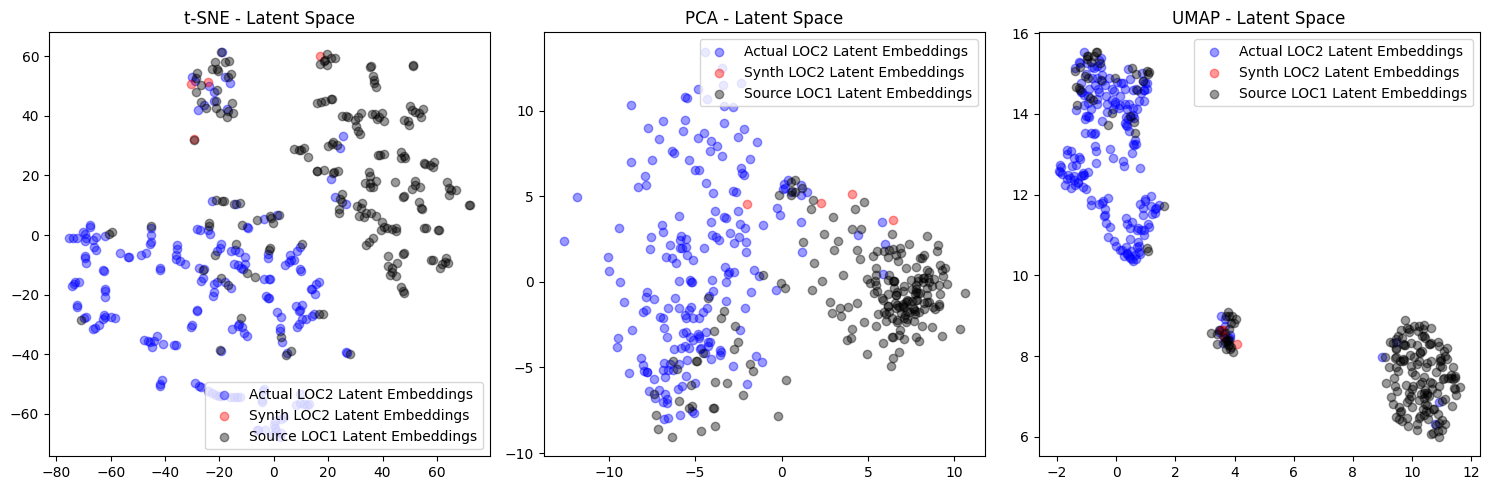

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import random
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

reducers = {'t-SNE': TSNE(n_components=2, learning_rate='auto',init='random', perplexity=3), 'PCA': PCA(n_components=2), 'UMAP': umap.UMAP()}


source_traces = test_df[(test_df['Location'] == source_location) & (
        test_df['Website'] == target_website)].iloc[:, 2:].to_numpy()


_, _, target_latent_embeddings = vae_model.encode(target_data)
_, _, synth_latent_embeddings = vae_model.encode(np.array(synthesized_vectors).reshape(num_samples, length))
_, _, source_latent_embeddings = vae_model.encode(source_traces)

combined_embeddings = np.concatenate((target_latent_embeddings, synth_latent_embeddings, source_latent_embeddings), axis=0)


def plt_scatter_location(embedding, label:str, color: str):    
    plt.scatter(
        embedding[:, 0],
        embedding[:, 1],
        alpha=0.4,
        label = label,
        c=color
    )

plt.figure(figsize=(15, 5))
i = 1
for reducer_name, reducer in reducers.items():
    combined_embeddings_reduced = reducer.fit_transform(combined_embeddings)

    # Separate embeddings
    target_embeddings_reduced = combined_embeddings_reduced[:len(target_latent_embeddings)]
    synth_embeddings_reduced = combined_embeddings_reduced[len(target_latent_embeddings): len(target_latent_embeddings) + len(synth_latent_embeddings)]
    source_embeddings_reduced = combined_embeddings_reduced[len(target_latent_embeddings) + len(synth_latent_embeddings): len(target_latent_embeddings) + len(synth_latent_embeddings) + len(source_latent_embeddings)]

    plt.subplot(1, len(reducers), i)
    plt_scatter_location(target_embeddings_reduced, 'Actual LOC2 Latent Embeddings', 'b')
    plt_scatter_location(synth_embeddings_reduced, 'Synth LOC2 Latent Embeddings', 'r')
    plt_scatter_location(source_embeddings_reduced, 'Source LOC1 Latent Embeddings', 'k')
    i += 1
    plt.legend()
    plt.tight_layout()
    plt.title(f"{reducer_name} - Latent Space")
plt.show()


# Triplet Embedding Visualization

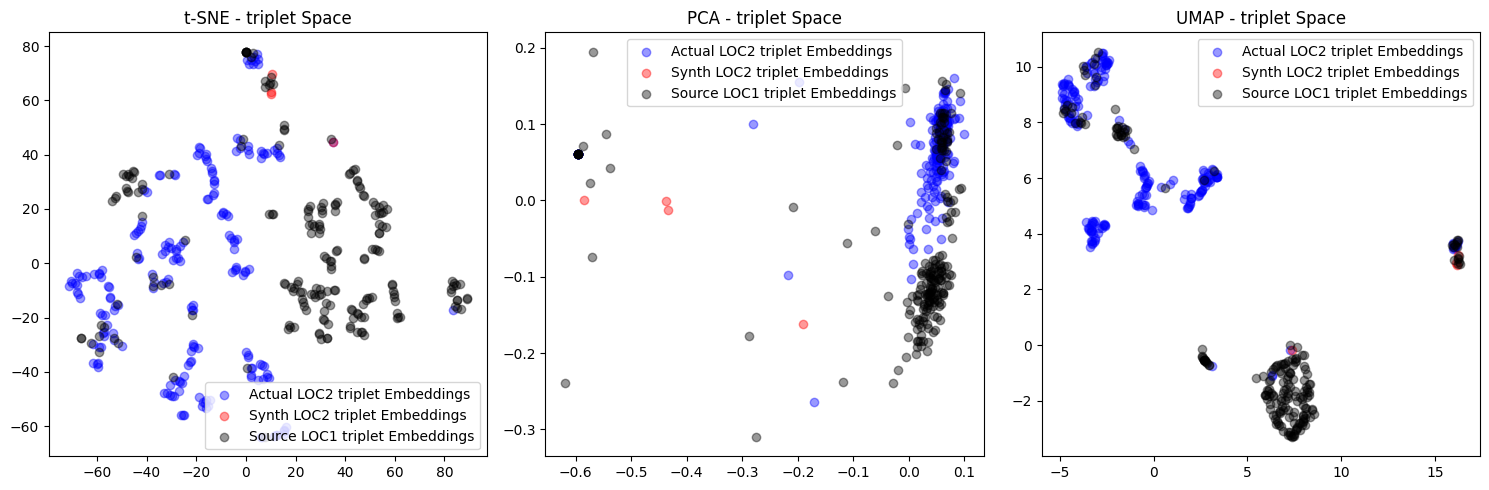

In [50]:
target_triplet_embeddings = web_model(target_data)
synth_triplet_embeddings = web_model(np.array(synthesized_vectors).reshape(num_samples, length))
source_triplet_embeddings = web_model(source_traces)

combined_embeddings = np.concatenate((target_triplet_embeddings, synth_triplet_embeddings, source_triplet_embeddings), axis=0)


def plt_scatter_location(embedding, label:str, color: str):    
    plt.scatter(
        embedding[:, 0],
        embedding[:, 1],
        alpha=0.4,
        label = label,
        c=color
    )

plt.figure(figsize=(15, 5))
i = 1
for reducer_name, reducer in reducers.items():
    combined_embeddings_reduced = reducer.fit_transform(combined_embeddings)

    # Separate embeddings
    target_embeddings_reduced = combined_embeddings_reduced[:len(target_triplet_embeddings)]
    synth_embeddings_reduced = combined_embeddings_reduced[len(target_triplet_embeddings): len(target_triplet_embeddings) + len(synth_triplet_embeddings)]
    source_embeddings_reduced = combined_embeddings_reduced[len(target_triplet_embeddings) + len(synth_triplet_embeddings): len(target_triplet_embeddings) + len(synth_triplet_embeddings) + len(source_triplet_embeddings)]

    plt.subplot(1, len(reducers), i)
    plt_scatter_location(target_embeddings_reduced, 'Actual LOC2 triplet Embeddings', 'b')
    plt_scatter_location(synth_embeddings_reduced, 'Synth LOC2 triplet Embeddings', 'r')
    plt_scatter_location(source_embeddings_reduced, 'Source LOC1 triplet Embeddings', 'k')
    i += 1
    plt.legend()
    plt.tight_layout()
    plt.title(f"{reducer_name} - triplet Space")
plt.show()
